In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# CGS constants
G = 6.67430e-8          # cm^3 g^-1 s^-2
M_sun = 1.98847e33      # g

df = pd.read_csv("../data/white_dwarf_data.csv")

# logg is in cgs by definition: log10(g[cm/s^2])
g = 10.0**df["logg"].to_numpy()        # cm/s^2 (CGS)

M_g = df["mass"].to_numpy() * M_sun    # g
R_cm = np.sqrt(G * M_g / g)            # cm

df["M_g"] = M_g
df["R_cm"] = R_cm

print(df.head())
print("N =", len(df))
print("R range [cm] =", np.min(R_cm), np.max(R_cm))

                           wdid   logg   mass           M_g          R_cm
0       2MASS J10145164+4541479  7.455  0.301  5.985295e+32  1.183711e+09
1          2QZ J114947.9-012045  8.497  0.907  1.803542e+33  6.191074e+08
2                     GJ 1179 B  7.783  0.454  9.027654e+32  9.965298e+08
3  Gaia DR2 1007682723024253184  7.885  0.510  1.014120e+33  9.391770e+08
4  Gaia DR2 1010300965150157824  8.035  0.600  1.193082e+33  8.571129e+08
N = 378
R range [cm] = 231154273.33282 1655222179.4030004


In [22]:
M_solar = df["mass"].to_numpy()   # Msun (dimensionless)
R = df["R_cm"].to_numpy()         # cm

#plt.figure()
#plt.plot(np.log10(R), np.log10(M_solar), ".", markersize=3)
#plt.xlabel(r"$\log_{10} R$ (cm)")
#plt.ylabel(r"$\log_{10} M$ ($M_\odot$)")
#plt.title("WD data: log-log (power-law check)")
#plt.grid(True, alpha=0.3)
#plt.show()

n* = 1.5
fixed slope s = -3.0
fitted intercept b = 26.682888953211748


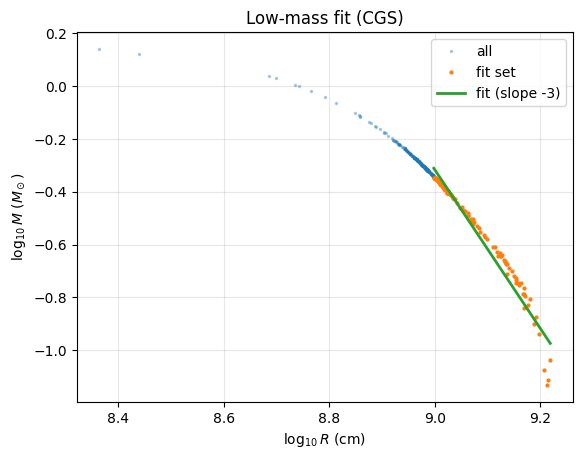

In [23]:
q = 3
n_star = q/(5-q)   # 1.5
s = -3.0           # (3-n)/(1-n) for n=1.5

logR = np.log10(R)
logM = np.log10(M_solar)

# low-mass cutoff seç 
mask = (M_solar <= 0.45)

b = np.mean(logM[mask] - s*logR[mask])   # best intercept for fixed slope
print("n* =", n_star)
print("fixed slope s =", s)
print("fitted intercept b =", b)

plt.figure()
plt.plot(logR, logM, ".", markersize=3, alpha=0.3, label="all")
plt.plot(logR[mask], logM[mask], ".", markersize=4, label="fit set")
xx = np.linspace(np.min(logR[mask]), np.max(logR[mask]), 200)
plt.plot(xx, s*xx + b, "-", linewidth=2, label="fit (slope -3)")
plt.xlabel(r"$\log_{10} R$ (cm)")
plt.ylabel(r"$\log_{10} M$ ($M_\odot$)")
plt.title("Low-mass fit (CGS)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [24]:
from scipy.integrate import solve_ivp

def lane_emden_constants(n, xi_max=200.0):
    xi0 = 1e-6
    y0 = [1.0 - xi0**2/6.0, -xi0/3.0]  # theta, theta'

    def rhs(xi, y):
        th, ph = y
        if th <= 0.0:
            return [ph, 0.0]
        return [ph, -2.0/xi * ph - th**n]

    def event_zero(xi, y):
        return y[0]
    event_zero.terminal = True
    event_zero.direction = -1

    sol = solve_ivp(rhs, (xi0, xi_max), y0, events=event_zero,
                    rtol=1e-10, atol=1e-12, max_step=0.05)

    if sol.status != 1 or sol.t_events[0].size == 0:
        raise RuntimeError("Lane-Emden: theta did not hit zero.")
    xi1 = sol.t_events[0][0]
    th1, ph1 = sol.y_events[0][0]
    omega_n = -xi1**2 * ph1
    return xi1, omega_n

xi1, omega_n = lane_emden_constants(n_star)
print("xi1 =", xi1)
print("omega_n =", omega_n)

xi1 = 3.653753736229732
omega_n = 2.714055163438723


In [25]:
# Fit line implies: M_g = M_sun * 10^b * R^s  (R in cm)
R_rep = 10.0**(np.mean(logR[mask]))             # cm
M_rep_g = (10.0**(s*np.log10(R_rep) + b)) * M_sun

A0 = (4.0*np.pi*omega_n) * (xi1**((3.0-n_star)/(n_star-1.0)))
pref = 4.0*np.pi*G/(n_star+1.0)                 # CGS G

K_star = pref * (M_rep_g / (A0 * (R_rep**s)))**((n_star-1.0)/n_star)

print("K* (CGS) =", K_star, " [dyn/cm^2] / [g/cm^3]^(1+1/n)")

K* (CGS) = 2791233232356.4614  [dyn/cm^2] / [g/cm^3]^(1+1/n)


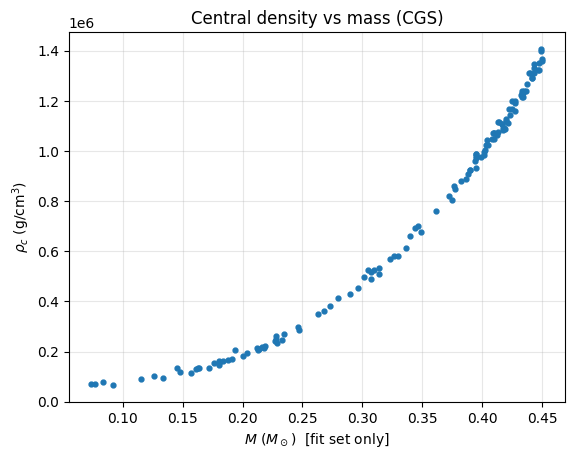

rho_c range [g/cm^3]: 66628.41724068476 to 1406967.1439696553


In [26]:
M_fit = M_solar[mask]     # Msun
R_fit = R[mask]           # cm

rho_c = (R_fit/xi1)**(2.0*n_star/(1.0-n_star)) * (4.0*np.pi*G/((n_star+1.0)*K_star))**(n_star/(1.0-n_star))

plt.figure()
plt.plot(M_fit, rho_c, ".", markersize=7)
plt.xlabel(r"$M$ ($M_\odot$)  [fit set only]")
plt.ylabel(r"$\rho_c$ (g/cm$^3$)")
plt.title(r"Central density vs mass (CGS)")
plt.grid(True, alpha=0.3)
plt.show()

print("rho_c range [g/cm^3]:", np.min(rho_c), "to", np.max(rho_c))